In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 119 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


importing libraries:

In [ ]:
import cv2
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn import svm, metrics
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from joblib import dump, load
import imblearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score


%matplotlib inline

In [ ]:
import os
GOOGLE_DRIVE_PATH_CODE = 'Colab Notebooks'
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive', GOOGLE_DRIVE_PATH_CODE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Tugba Sanver-NC CW-training.ipynb', 'Tugba Sanver-Test Notebook (2).ipynb', 'DRL', 'Computer Vision']


Unzipping the training dataset:

In [ ]:
#reference for this cell code: lab 07 solution

GOOGLE_DRIVE_PATH_ZIP = 'Colab Notebooks/Computer Vision/CW_Folder_PG(EC)/CW_Dataset'
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive', GOOGLE_DRIVE_PATH_ZIP)
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

!cp '{zip_path}' .
!yes|unzip -q CW_Dataset.zip
!rm CW_Dataset.zip

In [ ]:
#reference for this cell code: lab 09 solution

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cpu


Importing the training dataset:

In [ ]:
#reference for this cell code: lab 07 solution

images=[]

path='train'
file_names = [file for file in sorted(os.listdir(os.path.join(path))) if file.endswith('.jpg')]
for file in file_names:
    images.append(io.imread(os.path.join(path, file)))


In [ ]:
data_faces = pd.read_csv('/content/labels/list_label_train.txt', header=None, sep=',')
data_faces[['image_title', 'label']] = data_faces[0].str.split(' ', 1, expand=True)
labels_train=data_faces['label']

In [ ]:
print(Counter(labels_train))

Counter({'4': 4772, '7': 2524, '5': 1982, '1': 1290, '3': 717, '6': 705, '2': 281})


In [ ]:
label_names=np.array(labels_train)
label_names=np.unique(label_names)

In [ ]:
label_names

array(['1', '2', '3', '4', '5', '6', '7'], dtype=object)

Visualising label distribution of training data:

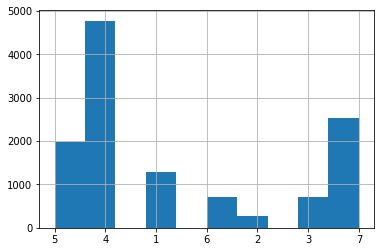

In [ ]:
labels_train.hist()

In [ ]:
labels_train.value_counts(normalize=True).mul(100).round(1)

4    38.9
7    20.6
5    16.2
1    10.5
3     5.8
6     5.7
2     2.3
Name: label, dtype: float64

It looks like slightly imbalanced dataset. However, there is no need to perform SMOTE oversampling technique as there will be very small change.

## **Model 1: SIFT+SVM** 

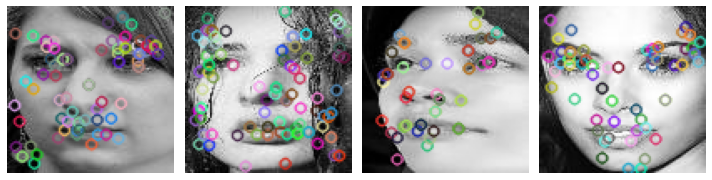

In [ ]:
#reference for this cell code: lab 07 solution

sift = cv2.SIFT_create()

des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(images)):
    img = img_as_ubyte(color.rgb2gray(images[i]))
    kp, des = sift.detectAndCompute(img, None)

    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(labels_train[i])

fig.tight_layout()
plt.show()

des_array = np.vstack(des_list)

In [ ]:
#reference for this cell code: lab 07 solution

# Number of centroids/codewords
k = len(np.unique(labels_train)) * 10

batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

In [ ]:
#reference for this cell code: lab 07 solution
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

Support Vector Classifier will be used for model fitting. Since it is a multiclass classification problem, OneVsRestClassifier will be used as SVM is normally designed for binary classification problems.

In [ ]:
#reference for this code cell is my own Neural Computing Coursework: https://drive.google.com/file/d/1cbgnWWKhq3hwZjg1DxNaRLbyiu71z1-a/view?usp=sharing
# Creating support vector classifier

classifier_sift = OneVsRestClassifier(SVC(kernel='rbf')).fit(hist_array, y_train_list)
scores = cross_validate(classifier_sift, hist_array, y_train_list, scoring='accuracy', cv=5)
scores


{'fit_time': array([38.48329449, 38.53580737, 37.70668817, 38.18698454, 37.69522715]),
 'score_time': array([9.24097753, 9.29218817, 9.07814479, 9.3573432 , 9.18544841]),
 'test_score': array([0.41174073, 0.41133306, 0.40847941, 0.40236445, 0.39845024])}

For hyperparameter tuning, it is good idea to perform a gridsearch to analyse the best possible settings. 

In [ ]:
#reference for this code cell is my own Neural Computing Coursework: https://drive.google.com/file/d/1cbgnWWKhq3hwZjg1DxNaRLbyiu71z1-a/view?usp=sharing

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
parameters = {
    "estimator__C": [0.08, 0.1, 0.8],
    "estimator__kernel": ["poly","rbf"],
}

gridsearch_svm = GridSearchCV(classifier_sift, parameters, verbose = 3, scoring='accuracy', refit=True, n_jobs=-1, cv=kfold)

gridsearch_svm.fit(hist_array, y_train_list)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.08, 0.1, 0.8],
                         'estimator__kernel': ['poly', 'rbf']},
             scoring='accuracy', verbose=3)

In [ ]:
gridsearchSVM=pd.DataFrame(gridsearch_svm.cv_results_)
gridsearchSVM

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,34.847658,0.480890,5.631332,0.038498,0.08,poly,"{'estimator__C': 0.08, 'estimator__kernel': 'p...",0.409002,0.409980,0.410959,0.409980,0.000799,3
1,44.312840,0.160687,13.393288,0.454954,0.08,rbf,"{'estimator__C': 0.08, 'estimator__kernel': 'r...",0.411693,0.409002,0.413160,0.411285,0.001722,2
2,34.537224,0.950067,5.619741,0.021093,0.1,poly,"{'estimator__C': 0.1, 'estimator__kernel': 'po...",0.407045,0.407534,0.409247,0.407942,0.000944,4
3,44.518267,0.783205,13.636548,0.448729,0.1,rbf,"{'estimator__C': 0.1, 'estimator__kernel': 'rbf'}",0.410714,0.409980,0.415362,0.412019,0.002383,1
4,39.572829,0.773561,5.345048,0.034334,0.8,poly,"{'estimator__C': 0.8, 'estimator__kernel': 'po...",0.388699,0.379159,0.383317,0.383725,0.003905,6
5,43.831566,0.570800,13.577115,0.461142,0.8,rbf,"{'estimator__C': 0.8, 'estimator__kernel': 'rbf'}",0.408513,0.407045,0.407290,0.407616,0.000642,5


Saving the model:

In [ ]:
#reference for this cell code: lab 07 solution

dump(classifier_sift, 'sift+svm.joblib') 

['sift+svm.joblib']

## **Model 2: HOG+SVM** 

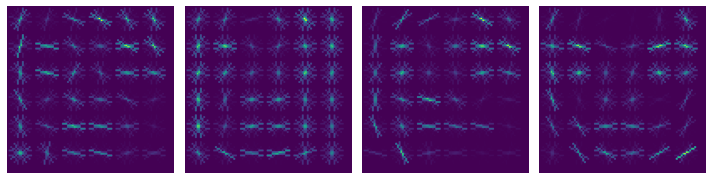

In [ ]:
#reference for this cell code: lab 07 solution

from skimage.feature import hog

y_train_list = []
HOG_des_list=[]
HOG_image_list=[]

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(images)):
    # Identify keypoints and extract descriptors with HOG
    img = img_as_ubyte(images[i])
    HOG_des, HOG_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    HOG_des_list.append(HOG_des)
    HOG_image_list.append(HOG_image)


    # Show results for first 4 images
    if i<4:
        ax[i].imshow(HOG_image)
        ax[i].set_axis_off()

    y_train_list.append(labels_train[i])

fig.tight_layout()
plt.show()


In [ ]:
print('HOG descriptor shape =', HOG_des.shape)

HOG descriptor shape = (288,)


Support Vector Classifier fitting:

In [ ]:
classifier_hog2 = OneVsRestClassifier(SVC(kernel='rbf')).fit(HOG_des_list, y_train_list)
scores = cross_validate(classifier_hog2, HOG_des_list, y_train_list, scoring='accuracy', cv=5)
scores


{'fit_time': array([53.71818066, 40.19627666, 42.72722864, 36.66119385, 35.77142644]),
 'score_time': array([13.02539325, 13.05397511, 12.14598107, 11.80511165, 11.60138106]),
 'test_score': array([0.62892057, 0.64914425, 0.62754686, 0.59698452, 0.58883456])}

Gridsearching:

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
parameters = {
    "estimator__C": [0.08, 0.1, 0.8],
    "estimator__kernel": ["poly","rbf"],
}

gs_hog_svm = GridSearchCV(classifier_hog2, parameters, verbose = 3, scoring='accuracy', refit=True, n_jobs=-1, cv=kfold)

gs_hog_svm.fit(HOG_des_list, y_train_list)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.08, 0.1, 0.8],
                         'estimator__kernel': ['poly', 'rbf']},
             scoring='accuracy', verbose=3)

In [ ]:
gridsearch_hs=pd.DataFrame(gs_hog_svm.cv_results_)
gridsearch_hs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,64.797031,1.243283,11.449778,0.486390,0.08,poly,"{'estimator__C': 0.08, 'estimator__kernel': 'p...",0.620142,0.627873,0.614425,0.620813,0.005510,1
1,75.168479,0.229582,27.581386,0.091618,0.08,rbf,"{'estimator__C': 0.08, 'estimator__kernel': 'r...",0.531655,0.535452,0.549878,0.538995,0.007850,6
2,70.104849,0.201275,10.897750,0.357954,0.1,poly,"{'estimator__C': 0.1, 'estimator__kernel': 'po...",0.619653,0.627384,0.611736,0.619591,0.006388,2
3,74.806781,0.291380,27.190189,0.337704,0.1,rbf,"{'estimator__C': 0.1, 'estimator__kernel': 'rbf'}",0.539477,0.544988,0.558680,0.547715,0.008073,5
4,95.290872,0.618650,8.229546,0.217936,0.8,poly,"{'estimator__C': 0.8, 'estimator__kernel': 'po...",0.604009,0.605623,0.597555,0.602396,0.003486,4
5,72.941080,0.088613,25.225622,0.504509,0.8,rbf,"{'estimator__C': 0.8, 'estimator__kernel': 'rbf'}",0.611586,0.610513,0.611980,0.611360,0.000620,3


Saving the model:

In [ ]:
dump(classifier_hog2, 'hog+svm.joblib') 

['hog+svm.joblib']

## **Model 3: CNN**

The data wrangling and structure for CNN is inspired(then modified a lot) from this source: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

Relevant type transformations:

In [ ]:
images_a=np.array(images)
train_label=np.array(labels_train)

train_img=[]
for i in range(len(images_a)):
  img = images_a[i].astype('float32')
  train_img.append(img)

train_img = np.array(train_img)
train_img.shape

(12271, 100, 100, 3)

Splitting data into training and validation sets with 80%-20% and shuffling:

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_img, train_label, test_size = 0.2, shuffle=True)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((9816, 100, 100, 3), (9816,)), ((2455, 100, 100, 3), (2455,)))

Torch transformations:

In [ ]:
train_x = train_x.reshape(9816, 3, 100, 100)
train_x  = torch.from_numpy(train_x)

train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

train_x.shape, train_y.shape

(torch.Size([9816, 3, 100, 100]), torch.Size([9816]))

In [ ]:
val_x = val_x.reshape(2455, 3, 100, 100)
val_x  = torch.from_numpy(val_x)

val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

val_x.shape, val_y.shape

(torch.Size([2455, 3, 100, 100]), torch.Size([2455]))

Model structure:

In [ ]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=7, stride=1, padding=5),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=2),
            nn.Conv2d(4, 4, kernel_size=7, stride=1, padding=5),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(4 *25 * 25, 8)
        )
   
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Optimiser and loss function:

In [ ]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

print(net)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=2500, out_features=8, bias=True)
  )
)


Training function:

In [ ]:
#code reference: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

def train(epoch):
    net.train()
    x_train, y_train = train_x, train_y
    x_val, y_val = val_x, val_y
    tr_loss = 0
    optimizer.zero_grad()
    
    # predictions:
    output_train = net(x_train)
    output_val = net(x_val)

    # training and validation loss:
    train_loss = criterion(output_train, y_train)
    val_loss = criterion(output_val, y_val)
    train_loss_ar = train_loss.detach().numpy() #reference: https://www.tutorialspoint.com/how-to-convert-a-pytorch-tensor-with-gradient-to-a-numpy-array
    val_loss_ar = val_loss.detach().numpy()
    train_losses.append(train_loss_ar)
    val_losses.append(val_loss_ar)

    # computing the updated weights of all the model parameters
    train_loss.backward()
    optimizer.step()
    tr_loss = train_loss.item()
    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', val_loss_ar)

Training for 200 epochs:

In [ ]:
n_epochs = 200

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : 1.9951112
Epoch :  11 	 loss : 1.6952018
Epoch :  21 	 loss : 1.5652745
Epoch :  31 	 loss : 1.4839824
Epoch :  41 	 loss : 1.4211426
Epoch :  51 	 loss : 1.3629701
Epoch :  61 	 loss : 1.3233631
Epoch :  71 	 loss : 1.287325
Epoch :  81 	 loss : 1.2564034
Epoch :  91 	 loss : 1.2286936
Epoch :  101 	 loss : 1.2060577
Epoch :  111 	 loss : 1.1876062
Epoch :  121 	 loss : 1.1734674
Epoch :  131 	 loss : 1.1627651
Epoch :  141 	 loss : 1.1554815
Epoch :  151 	 loss : 1.1503793
Epoch :  161 	 loss : 1.1438264
Epoch :  171 	 loss : 1.1516832
Epoch :  181 	 loss : 1.1463549
Epoch :  191 	 loss : 1.1369705


Training and validation loss plottings:

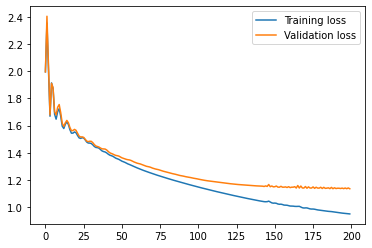

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

Results and accuracy scores:

In [ ]:
#code reference: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

with torch.no_grad():
    output = net(train_x)
    
softmax = torch.exp(output) #softmax because of the multiclass labels
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.6653422982885085

Saving model:

In [ ]:
PATH = './cnn_net.pth'
torch.save(net.state_dict(), PATH)